# Exploratory Data Analysis

In [1]:
%matplotlib inline

import re
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from nltk import download
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv('../data/train.tsv', sep='\t')
print("Number of items: {}".format(len(df)))
df.head()

Number of items: 1482535


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


### Data fields

#### train.tsv, test.tsv

- `train_id` or `test_id` - the id of the listing

- name - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]

- `item_condition_id` - the condition of the items provided by the seller

- `category_name` - category of the listing

- `brand_name`

- `price` - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.

- `shipping` - 1 if shipping fee is paid by seller and 0 by buyer

- `item_description` - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]

[Reference](https://www.kaggle.com/c/mercari-price-suggestion-challenge/data)

### Accumulations in General

In [3]:
price = df["price"]
price.describe().apply(lambda x: format(x, 'f'))

count    1482535.000000
mean          26.737516
std           38.586066
min            0.000000
25%           10.000000
50%           17.000000
75%           29.000000
max         2009.000000
Name: price, dtype: object

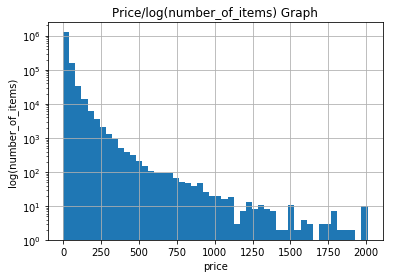

In [4]:
price.hist(log=True, bins=50)
plt.title("Price/log(number_of_items) Graph")
plt.xlabel("price")
plt.ylabel("log(number_of_items)")
plt.show()

Prices of items are mostly accumulated in the range between 0 to 250 USD.

In [5]:
zeros = np.where(price==0)
print("Number of free items: {}".format(zeros[0].size))

Number of free items: 874


In [6]:
category_counts = df["category_name"].value_counts()
print("Most frequent categories:")
category_counts.head(20)

Most frequent categories:


Women/Athletic Apparel/Pants, Tights, Leggings                 60177
Women/Tops & Blouses/T-Shirts                                  46380
Beauty/Makeup/Face                                             34335
Beauty/Makeup/Lips                                             29910
Electronics/Video Games & Consoles/Games                       26557
Beauty/Makeup/Eyes                                             25215
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24676
Women/Underwear/Bras                                           21274
Women/Tops & Blouses/Tank, Cami                                20284
Women/Tops & Blouses/Blouse                                    20284
Women/Dresses/Above Knee, Mini                                 20082
Women/Jewelry/Necklaces                                        19758
Women/Athletic Apparel/Shorts                                  19528
Beauty/Makeup/Makeup Palettes                                  19103
Women/Shoes/Boots                 

Women related categories clearly predominates. Also many categories under beauty shows up. Let's look at first-level categories.

In [7]:
def first_level_cat(x):
    p = re.compile("[^/]*")
    try:
        return p.match(x).group()
    except TypeError:
        return "None"

categories = df.copy(deep=True)
first_level_categories = categories["category_name"].apply(first_level_cat)
first_level_category_counts = first_level_categories.value_counts()
print("Most frequent first-level categories:")
first_level_category_counts.head(20)

Most frequent first-level categories:


Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
None                        6327
Name: category_name, dtype: int64

Women category four times frequent than its nearest, which is Beauty, which is also probably mostly women related. We can assume majority of platform users are women.

In [8]:
item_condition = df["item_condition_id"]
print("Item conditions:")
print("1: new\n2: like new\n3: good\n4: fair\n5: poor")
print("-----------------------")
print("Item condition counts:")
item_condition.value_counts()

Item conditions:
1: new
2: like new
3: good
4: fair
5: poor
-----------------------
Item condition counts:


1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

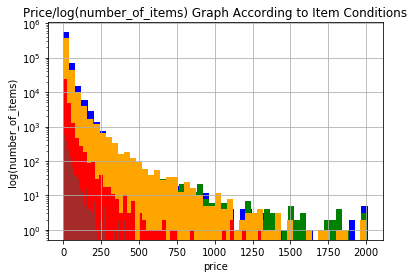

blue: new
green: like new
orange: good
red: fair
brown: poor


In [9]:
condition_colors = ['blue', 'green', 'orange', 'red', 'brown']
for i, color in enumerate(condition_colors):
    plot_df = df.query('item_condition_id == {}'.format(i+1))
    plot_df['price'].hist(log=True, color=color, bins=50)
plt.title("Price/log(number_of_items) Graph According to Item Conditions")
plt.xlabel("price")
plt.ylabel("log(number_of_items)")
plt.show()
print("blue: new\ngreen: like new\norange: good\nred: fair\nbrown: poor")

From new to poor conditions the longness of the graphs' tail increases. So obviously the better condition one item has, the more expensive it is. Nothing unexpected.

In [10]:
shipping_status = df["shipping"]
print("Shipping statuses:")
print("1: paid shipping\n2: non-paid shipping")
print("-----------------------")
print("Shipping status counts:")
shipping_status.value_counts()

Shipping statuses:
1: paid shipping
2: non-paid shipping
-----------------------
Shipping status counts:


0    819435
1    663100
Name: shipping, dtype: int64

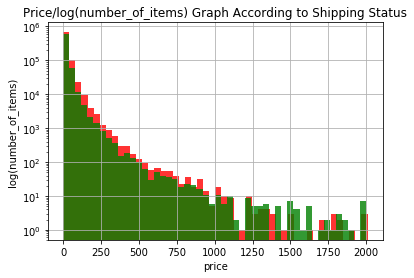

green: paid shipping
red: non-paid shipping


In [11]:
condition_colors = ['red', 'green']
for i, color in enumerate(condition_colors):
    plot_df = df.query('shipping == {}'.format(i))
    plot_df['price'].hist(log=True, color=color, bins=50, alpha=0.8)
plt.title("Price/log(number_of_items) Graph According to Shipping Status")
plt.xlabel("price")
plt.ylabel("log(number_of_items)")
plt.show()
print("green: paid shipping\nred: non-paid shipping")

Shipping cost of items costing more than 1250 USD are mostly paid by sellers.

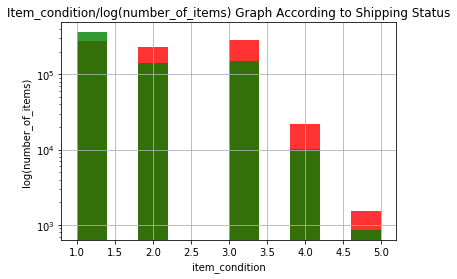

green: paid shipping
red: non-paid shipping
-----------------------
1: new
2: like new
3: good
4: fair
5: poor


In [12]:
condition_colors = ['red', 'green']
for i, color in enumerate(condition_colors):
    plot_df = df.query('shipping == {}'.format(i))
    plot_df['item_condition_id'].hist(log=True, color=color, alpha=0.8)
plt.title("Item_condition/log(number_of_items) Graph According to Shipping Status")
plt.xlabel("item_condition")
plt.ylabel("log(number_of_items)")
plt.show()
print("green: paid shipping\nred: non-paid shipping")
print("-----------------------")
print("1: new\n2: like new\n3: good\n4: fair\n5: poor")

In [13]:
brand_counts = df["brand_name"].value_counts()
print("Most frequent brands:")
brand_counts.head(20)

Most frequent brands:


PINK                 54088
Nike                 54043
Victoria's Secret    48036
LuLaRoe              31024
Apple                17322
FOREVER 21           15186
Nintendo             15007
Lululemon            14558
Michael Kors         13928
American Eagle       13254
Rae Dunn             12305
Sephora              12172
Coach                10463
Disney               10360
Bath & Body Works    10354
Adidas               10202
Funko                 9237
Under Armour          8461
Sony                  7994
Old Navy              7567
Name: brand_name, dtype: int64

### Expensiveness

In [14]:
def price_median(x, limit=0):
    return x["price"].median() if len(x) > limit else 0

expensives = df.copy(deep=True)
expensive_brands = expensives.groupby(['brand_name'])
print("Most expensive brands according to price mean:")
expensive_brands.apply(price_median).sort_values(ascending=False).head(20)

Most expensive brands according to price mean:


brand_name
Demdaco                429.0
Auto Meter             344.0
Proenza Schouler       315.5
Oris                   300.0
Longines               254.0
Blendtec               250.0
Dainese                230.0
Frédérique Constant    224.0
David Yurman           220.0
Vitamix                205.0
iRobot                 204.5
Alexander Wang         200.0
Alyce Paris            200.0
Brioni                 200.0
Stephen Webster        200.0
Contours               200.0
Tag Heuer              187.5
EVGA                   186.0
Mackintosh             185.0
Tiffany Designs        182.5
dtype: float64

In [15]:
limit = 1000
print("Most expensive and popular (having at least {} items listed) brands according to price mean:".format(limit))
expensive_brands.apply(lambda x: price_median(x, limit=limit)).sort_values(ascending=False).head(20)

Most expensive and popular (having at least 1000 items listed) brands according to price mean:


brand_name
Louis Vuitton          106.0
Air Jordan              80.0
Tiffany & Co.           70.0
Tory Burch              65.0
Beats                   64.0
Gucci                   64.0
Beats by Dr. Dre        60.0
Rock Revival            55.0
Jordan                  55.0
Kendra Scott            52.0
Fitbit                  50.0
Ray-Ban                 50.0
Michael Kors            49.0
Kate Spade              46.0
UGG Australia           46.0
patagonia               45.0
Dooney & Bourke         41.0
Fuji                    39.0
Lululemon               39.0
lululemon athletica     39.0
dtype: float64

In [16]:
expensive_categories = df.groupby(['category_name'])
print("Most expensive categories according to price mean:")
expensive_categories.apply(price_median).sort_values(ascending=False).head(20)

Most expensive categories according to price mean:


category_name
Vintage & Collectibles/Antique/Furniture                           195.0
Kids/Strollers/Standard                                            145.0
Home/Home Appliances/Air Conditioners                              131.0
Kids/Strollers/Lightweight                                         105.0
Electronics/Computers & Tablets/Laptops & Netbooks                 100.0
Sports & Outdoors/Golf/Women's Golf Clubs                          100.0
Kids/Strollers/Travel Systems                                       95.0
Women/Women's Handbags/Satchel                                      90.0
Electronics/Computers & Tablets/Desktops & All-In-Ones              89.5
Handmade/Woodworking/Sports                                         86.0
Other/Automotive/Oils & Fluids                                      85.0
Handmade/Pets/Blanket                                               71.0
Electronics/Cameras & Photography/Lenses & Filters                  70.0
Men/Sweats & Hoodies/Track & Sweat Su

In [17]:
print("Most expensive first-level categories according to price mean:")
categories.groupby(first_level_categories).apply(price_median).sort_values(ascending=False).head(20)

Most expensive first-level categories according to price mean:


category_name
Men                       21.0
Women                     19.0
Home                      18.0
Vintage & Collectibles    16.0
Sports & Outdoors         16.0
None                      16.0
Electronics               15.0
Beauty                    15.0
Other                     14.0
Kids                      14.0
Handmade                  12.0
dtype: float64

### Words inside Item Descriptions

In [18]:
download("stopwords")
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/ml/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Words are count after removing stop words.

In [19]:
descriptions = df.copy(deep=True)
descriptions = descriptions.dropna(subset=["item_description"], how="any")
word_list = " ".join(descriptions["item_description"]).lower().split()
print("Most frequent words inside item descriptions excluding stop words:")
pd.Series([word if word not in stop_words else None for word in word_list]).value_counts()[:20]

Most frequent words inside item descriptions excluding stop words:


size         396514
new          387562
brand        250587
free         236446
[rm]         169715
-            156260
never        155307
shipping     146079
great        144576
worn         142741
used         138352
black        126197
&            123305
price        118677
condition    115321
2            110028
one          109437
like         107168
please       103482
bundle       101203
dtype: int64